##               <center>Text Mining to Decipher Free-Response Consumer Complaints</center>

The **objective** of this study is to identify clusters of vehicle problems from free response consumer complaints database and associated year trend. Database used in this study is the latest database and I wanted to compare the clusters obtained in the  study done in 2012. The number of complaints has significantly increased since 2012 with **1.4 million** complaints in the latest database and **0.7 million** complaints in the database from 2012. There can be several reasons for the increased number of complaints such as increased car sales, associated manufacturing defects and company recalls. 

Two severity levels from free-response data i.e. fatal incidents and incidents involving injury were analyzed using text mining method and singular value decompostion(SVD) to reduce the dimensionality of text data, followed by K-means clustering to make clusters.

In [537]:
# Loading required libraries

import numpy as np
import pandas as pd
import re, string, nltk
from string import punctuation
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import _pickle as cPickle
import time
import numpy
from pylab import *
import random
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, FeatureHasher
from nltk.stem.porter import*
from nltk.stem import PorterStemmer, WordNetLemmatizer
stop = set(stopwords.words('english'))
random.seed(1)

In [374]:
# Loading data

data= pd.read_csv("C:/Users/Ashish/Desktop/New folder/Project/csv/data_new.csv", encoding='mac_roman')

In [375]:
data.drop('Unnamed: 0', axis=1, inplace=True)  # Dropping unnecesary empty column
data.head()

,CMPLID,MAKETXT,MODELTXT,CRASH,FAILDATE,INJURED,DEATHS,COMPDESC,LDATE,CDESCR
0,1,GERRY,CHILD SAFETY SEAT,NaN,19941231.0,0.0,0.0,CHILD SEAT,19950103,STRESS CRACKS AROUND FRONT PLASTIC HINGE. TT
1,2,FORD,PROBE,NaN,19950103.0,0.0,0.0,SEAT BELTS:FRONT:RETRACTOR,19950103,DRIVER SEAT BELT RETRACTOR STOPS WORKING WHEN ...
2,3,FORD,WINDSTAR,NaN,19940808.0,0.0,0.0,"SERVICE BRAKES, HYDRAULIC:FOUNDATION COMPONENTS",19950103,DURING BRAKE APPLICATION VEHICLE EXHIBITS A GR...
3,4,CHEVROLET,CAPRICE,Y,19950102.0,0.0,0.0,VEHICLE SPEED CONTROL,19950103,THROTTLE STICKS WHICH CAUSED AN ACCIDENT. TT
4,5,HONDA,CIVIC,Y,19941106.0,0.0,0.0,AIR BAGS:FRONTAL,19950103,DRIVER AIR BAG DID NOT DEPLOY DURING FRONTAL C...


In [376]:
data.shape

(1441599, 10)

In [377]:
data['FAILDATE']=data['FAILDATE'].astype(str)
data['FAILDATE']=data['FAILDATE'].apply(lambda x: x[:4])

In [378]:
# There is a limitation in Python where we cannot convert a column to integer if it has NA values, so converting to float. It 
# doe not affect our analysis.

data['FAILDATE']=data['FAILDATE'].astype(float)

Finding number and percentage of cases in the Database organized by the 'Injury' and 'Deaths' field

In [379]:
# At least one death reported
death_data= data[data['DEATHS']>0]

# No deaths and at least one injury reported
injury_data= data.loc[(data['INJURED']>0) & (data['DEATHS']==0) & (data['INJURED']<99)] 

# No injuries or deaths reported
no_injury_death= data.loc[(data['INJURED']==0) & (data['DEATHS']==0)]

# No injuries reported, missing fatality data
no_injury_missingdeath= data.loc[(data['INJURED']==0) & (data['DEATHS'].isnull())]

# At least one injury reported, missing fatality data
injury_missingdeath= data.loc[(data['INJURED']>0) & (data['DEATHS'].isnull())]

# No deaths reported, missing injury data
no_death_missinginjury= data.loc[(data['INJURED'].isnull()) & (data['DEATHS']==0)]

# Missing both injury and fatality data
missing_death_injury= data.loc[(data['INJURED'].isnull()) & (data['DEATHS'].isnull())]

In [380]:
number_of_cases= [death_data.shape[0], injury_data.shape[0], no_injury_death.shape[0], no_injury_missingdeath.shape[0],
                  injury_missingdeath.shape[0],no_death_missinginjury.shape[0], missing_death_injury.shape[0]]

In [381]:
Injury_and_Death_Involvement= ['At least one death reported', 'No deaths and at least one injury reported',
                               'No injuries or deaths reported','No injuries reported, missing fatality data',
                              'At least one injury reported, missing fatality data','No deaths reported, missing injury data',
                               'Missing both injury and fatality data']

In [1088]:
table=pd.DataFrame([Injury_and_Death_Involvement, number_of_cases]).T
table.columns= ['Injury and Death Involvement', 'Number of Cases']
table['Proportion of the Database (%)'] = table['Number of Cases']/data.shape[0]

### Table: Number and Percentage of cases in the Database organized by the 'Injury' and 'Deaths' field

In [1089]:
table

,Injury and Death Involvement,Number of Cases,Proportion of the Database (%)
0,At least one death reported,3619,0.00251041
1,No deaths and at least one injury reported,40772,0.0282825
2,No injuries or deaths reported,583480,0.404745
3,"No injuries reported, missing fatality data",3135,0.00217467
4,"At least one injury reported, missing fatality data",25430,0.0176401
5,"No deaths reported, missing injury data",9655,0.00669742
6,Missing both injury and fatality data,775500,0.537944


Incidents involving injury are around 3% of the data and incidents involving atleast 1 death are around 0.25% of the data. 93% of the data comprised of either missing both injury and death related data or no injuries and deaths reported. The focus of our study is only on incidents involving atleast 1 death and incidents involving no death and atleast 1 injury.
Since their is a disparity between number of cases in injury data and deaths data, we will take a random sample consiting only 2500 complaints of incidents involving injury.

### Analyzing data involving atleast 1 death.

In [384]:
import warnings
warnings.filterwarnings("ignore")

death_data= data[data['DEATHS']>0]

# Fixing the airbag issue.
death_data['CDESCR']= death_data['CDESCR'].str.replace('AIR BAG', 'AIRBAG') 

# Removing duplicate rows
death_data = death_data.drop_duplicates('CDESCR')

# Removing empty Description rows
death_data = death_data[~death_data['CDESCR'].isnull()]

In [385]:
death_data['DEATHS'].unique()

array([  1.,   3.,   4.,   2.,   9.,  15.,   5.,   6.,  10.,  16.,  17.,
         7.,  18.,  12.,  11.,  99.,  95.,   8.,  88.,  50.,  45.])

In [386]:
# Checking what those large integer values in Deaths column correspond to.
death_data[death_data['DEATHS']>20]

,CMPLID,MAKETXT,MODELTXT,CRASH,FAILDATE,INJURED,DEATHS,COMPDESC,LDATE,CDESCR
538149,538150,YAMAHA,FZ6,N,2005.0,99.0,99.0,"FUEL SYSTEM, GASOLINE:DELIVERY",20050418,"1-AVERAGE USAGE, 2-MOTORCYCLES WOULD STALL S..."
545329,545330,LITTLE GUY,RASCAL,N,2005.0,10.0,95.0,POWER TRAIN,20050607,I WAS SHOOTING THE ENGINE WITH MY M16 WHEN IT ...
582850,582851,MAZDA,626,Y,2006.0,99.0,99.0,POWER TRAIN:AUTOMATIC TRANSMISSION,20060320,MAZDA 626 TRANSMISSION CD4E IS FAULTY. WHY SH...
592695,592696,FEDERAL,ADVENTURE,Y,2006.0,99.0,88.0,EQUIPMENT:ELECTRICAL:NAVIGATIONAL SYSTEM(GLOBA...,20060626,WHY DON'T YOU TAKE YOUR CLICK IT OR TICKET PRO...
602562,602563,HONDA,RIDGELINE,N,2006.0,NaN,99.0,EQUIPMENT,20060915,"ON AUGUST 15, I PURCHASED A HONDA RIDGELINE 20..."
734822,734823,FORD,FORD TRUCK AND VAN,N,2004.0,99.0,99.0,TIRES,20090813,;KJLKJ. *TR
751959,751960,DODGE,DURANGO,N,2009.0,99.0,99.0,"SERVICE BRAKES, HYDRAULIC",20091216,EARLY GENERATION DODGE DURANGO (98-01) HAS ABS...
1081834,1081835,FORD,EXPLORER,Y,2010.0,10.0,50.0,VEHICLE SPEED CONTROL,20140629,"BOUGHT CAR FROM BATES FORD IN LEBANON, TN NEW...."
1255378,1255379,TOYOTA,HIGHLANDER,Y,2014.0,3.0,45.0,AIR BAGS,20160121,CAR IN MOTION @45 MILES AN HOUR AT 8AM 12/29/1...


Looking at the data for number of deaths greater than 20, it seems there is some error with number of deaths reported as number of injured are also same when deaths=99. 
We will later drop rows in the injury data corresponding to INJURED=99.

In [387]:
death_data= death_data[death_data['DEATHS']<50]

In [388]:
death_data.shape

(2457, 10)

We have 2457 responses associated with Deaths>0 and Deaths<50.

### Data Pre-processing

Creating a set of stopwords. Stopwords from previous study are used  here and adding 6 additional stopwords i.e. 'skd', 'upon', 'would' and 'problem', 'could' and 'know'.

In [389]:
stemmer = SnowballStemmer("english")

In [538]:
i = stopwords.words('english')
j = list(string.punctuation) 
my_stopwords = ['vehicl', 'car',  'result', 'kill', 'time', 'report', 'drive', 'driver', 'caus',
                  'fatal', 'involv', 'death', 'updat', 'son', 'daughter', 'left', 'right', 'investig', 'occur', 'impact',
                  'fail', 'believ', 'pleas', 'mother', 'father', 'due', 'husband', 'wife', 'happen', 'summari',
                  'travel', 'failur', 'lost', 'consum', 'concern', 'compani', 'found', 'list', 'feel', 'mile', 'mileag',
                  'mph', 'caught', 'incid', 'famili', 'wit', 'becaus', 'die', 'road', 'polic', 'anoth', 'injuri', 'attorney',
                  'dure', 'possibl', 'client', 'accid','XXXX','tlthe', 'skd','upon', 'would', 'problem', 'could', 'know', 'get',
               'also', 'dealer']


stopwords = set(i).union(j,my_stopwords)

In [539]:
# Defining a function to preprocess and clean the text data similar to Text Mining package in R.

def preprocess(x):
    x = re.sub('[^a-z\s]',' ', x.lower())                      # Removing noise from Description
    x = [stemmer.stem(w) for w in x.split() if stemmer.stem(w) not in set(stopwords)]   # Removing words not in list of stopwords
    x= [y for y in x if len(y)>2]                           # Removing words with length less than 2 characters.
    x= list(set(x))
    return ' '.join(x)

In [540]:
death_data["CDESCR"] = death_data['CDESCR'].apply(preprocess)

In [541]:
# Dropping rows with duplicate values in 'CDESCR' column
death_data = death_data.drop_duplicates('CDESCR')

In [542]:
death_data.shape

(2419, 10)

In [543]:
# Cleaned text data
death_data['CDESCR'].head(10)

585                                          sudden accel
1118                                 gas fire explod tank
1291                             tank passeng explod fuel
2381                                 locat batteri explod
2518    undetermin detail safeti combin seat child sea...
3060    ruptur tank frontal fuel torsion ignit fire ba...
3269                          deploy colli frontal airbag
3692    sever booster broadsid hit open thrown cosco v...
3756         fact belt lap seat coron state part shoulder
4314     motor passeng belt thrown track broke windshield
Name: CDESCR, dtype: object

Now we will be creating a Term-Document Matrix with inverse document frequency set to True. When we create TF-IDF matrix, it gives low weight to the words with high frequency. Then, we will apply Singular Value Decomposition(SVD) to reduce the dimensionality of the term-document matrix.

In [544]:
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent

        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        tokens = list(filter(lambda t: t not in punctuation, tokens))
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', 
                                            u'\u2014', u'\u2026', u'\u2013'], tokens))
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

In [1076]:
vectorizer = TfidfVectorizer(min_df=2, max_features=10000,tokenizer=tokenizer, max_df=0.5, ngram_range=(1,1), use_idf=True)
X = vectorizer.fit_transform(list(death_data['CDESCR']))
X.shape

(2419, 3072)

In [1077]:
svd = TruncatedSVD(100)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
X.shape

(2419, 100)

### KMeans Clustering

Now that we have reduced the dimensions of our term-document matrix, we can now use KMeans clustering to identify the clusters. Since, I have some idea how approximately how many clusters I need to make based on previous study, I decided to use KMeans clustering since I was having some difficulty obtaining clusters using Hierarchical clustering method.

In [588]:
from sklearn.cluster import MiniBatchKMeans, KMeans

num_clusters = 8
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, 
                          verbose=False, max_iter=1000, random_state=10)
kmeans = kmeans_model.fit(X)
kmeans_clusters = kmeans.predict(X)
kmeans_distances = kmeans.transform(X)

In [589]:
clusters= pd.DataFrame(kmeans_clusters, columns=['clusters'])

In [590]:
death_data1=death_data.reset_index().drop('index', axis=1)

In [591]:
death_data1=pd.concat([death_data1[['FAILDATE', 'CDESCR']], clusters], axis=1)

In [592]:
cluster = dict()
counts= dict()
for i in range(8):
    cluster[i]= death_data1[death_data1['clusters']==i]

In [593]:
for i in range(8):
    counts[i]= cluster[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)

### Wordclouds for each cluster

Creating wordcloud for each clusters and showing the top ten words by frequency.

In [594]:
from wordcloud import WordCloud

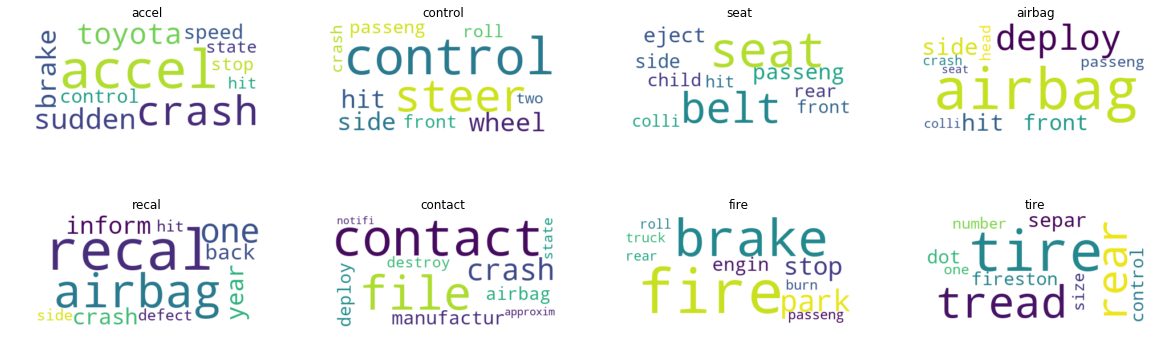

In [1080]:
plt.figure(figsize=(20,20));
wordcloud=dict()
for i in range(num_clusters):
    counts[i]= cluster[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)
    wordcloud[i] = WordCloud(background_color='white', max_words=10).fit_words(counts[i])
    plt.subplot(6,4,i+1);
    plt.subplots_adjust(hspace=0.5, wspace=0.3);
    plt.imshow(wordcloud[i], interpolation='bilinear')
    plt.title(counts[i].index[0])
    plt.axis("off")
plt.show();

From the above wordclouds, we can notice that 6 of the clusters are same as in the previous study with the most frequent terms as ** control, contact, tire, fire, seat and airbag**. The only clusters different are **recal** and **acceler** replacing **passeng** and **brake** from the previous study. 

Tire cluster corresponds to the famous Ford/Firestone tire controversy involving rear tire tread seperation resulting in controll loss.

acceler *[accelertion]* cluster corresponds to the Toyota unintened acceleration causing control loss.

airbag and passeng terms appears in many of the clusters.

In the previous study, the cluster with maximum number of complaints was **passeng**, as appose to the  **control** cluster in this study.

In [597]:
# Creating table for the Most Frequent Terms in Each CLuster Identified in Fatal Incidents

freq_terms=pd.DataFrame(death_data1.groupby('clusters')['CDESCR'].count())
freq_terms.columns= ['# of Complaints']
freq_terms['Most Frequent Terms']= ''
freq_terms['Frequency of the Most Frequent Terms']=''

x=[]
for i in range(num_clusters):
    x.append(counts[i].index)

for i in range(num_clusters):
    freq_terms.at[i,'Most Frequent Terms']=list(x[i])

y=[]
for i in range(num_clusters):
    y.append(counts[i].values)

for i in range(num_clusters):
    freq_terms.at[i,'Frequency of the Most Frequent Terms']=list(y[i])

### Table: The most frequent terms in each cluster identified in Fatal Incidents

In [1084]:
freq_terms

,# of Complaints,Most Frequent Terms,Frequency of the Most Frequent Terms
clusters,,,
0,190,"[accel, sudden, crash, toyota, speed, brake, control, stop, state, hit]","[153, 76, 76, 70, 61, 61, 60, 50, 46, 41]"
1,281,"[control, steer, wheel, hit, side, roll, passeng, front, two, crash]","[134, 103, 71, 66, 62, 55, 54, 51, 41, 41]"
2,268,"[seat, belt, passeng, eject, side, child, rear, colli, front, hit]","[243, 185, 84, 77, 59, 58, 55, 49, 48, 44]"
3,339,"[airbag, deploy, hit, side, front, passeng, head, colli, crash, seat]","[334, 308, 112, 112, 94, 92, 87, 69, 61, 48]"
4,491,"[recal, inform, year, one, crash, airbag, defect, back, hit, side]","[175, 114, 113, 113, 109, 108, 104, 101, 92, 90]"
5,186,"[contact, crash, file, manufactur, airbag, deploy, destroy, state, approxim, notifi]","[181, 151, 151, 141, 125, 123, 117, 111, 87, 85]"
6,451,"[fire, brake, park, rear, stop, engin, fuel, truck, passeng, roll]","[124, 93, 82, 57, 56, 55, 51, 50, 49, 48]"
7,213,"[tire, tread, rear, separ, dot, fireston, control, size, number, one]","[203, 109, 104, 98, 91, 87, 79, 66, 65, 54]"


### Time Trend Analysis of Fatal Incidents Clusters

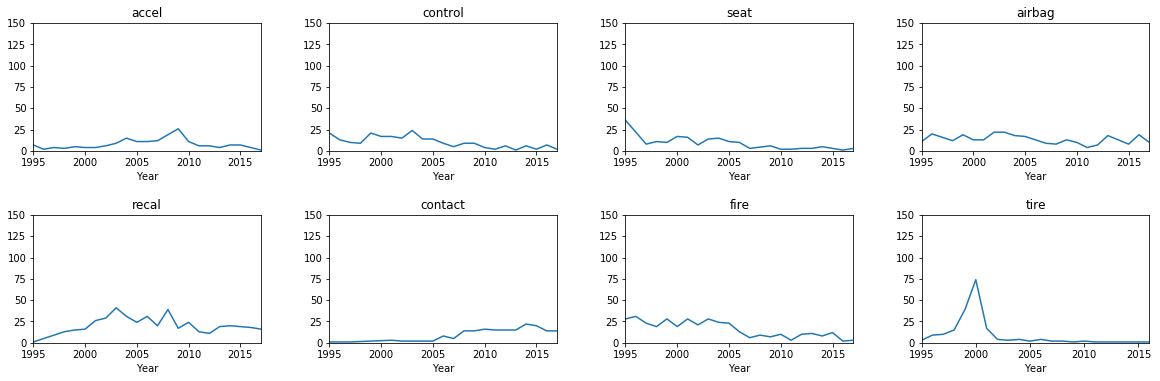

In [599]:
plt.figure(figsize=(20,20));
for i in range(num_clusters):
    cluster[i]= death_data1[death_data1['clusters']==i]
    cluster[i]=cluster[i][cluster[i]['FAILDATE']>1994]
    counts[i]= cluster[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)
    plt.subplot(6,4,i+1);
    plt.subplots_adjust(hspace=0.5, wspace=0.3);
    cluster[i].groupby('FAILDATE')['clusters'].count().plot(title=counts[i].index[0]);
    plt.xlabel("Year");
    
    plt.ylim((0,150));
plt.show();
plt.tight_layout();

From the above time-trend graphs, we can notice that **tire** cluster has the highest disturbance around year 2000 corresponding to the Ford/Firestone tire tread seperation issue.

**control** and **seat** clusters show decreasing trend which may be related to advancement in vehicle technology such as Electronic Stability Control, collision warning and Seatbelt pretensioners.

**acceler** cluster saw a peak in 2009 which may be related to Toyota unintended acceleration problem.

**contact** cluster has been constant since the last 10 years, but we can notice an increasing trend after 2005 which may be related to surge in number of vehicles on roads.

### Analyzing data involving atleast 1 injury and no death.

In [410]:
injury_data= data.loc[(data['INJURED']>0) & (data['DEATHS']==0) & (data['INJURED']<99)]

# Fixing the airbag issue.
injury_data['CDESCR']= injury_data['CDESCR'].str.replace('AIR BAG', 'AIRBAG')

# Removing duplicate rows.
injury_data = injury_data.drop_duplicates('CDESCR')

# Removing empty Description rows
injury_data = injury_data[~injury_data['CDESCR'].isnull()]

In [411]:
# Taking a random sample of 2500 complaints from injury data.
injury_data= injury_data.sample(2500)

In [600]:
## Pre-processing injury text description using the function created before
injury_data["CDESCR"] = injury_data['CDESCR'].apply(preprocess)

In [601]:
# Removing duplicate rows.
injury_data = injury_data.drop_duplicates('CDESCR')

In [1081]:
vectorizer_injury = TfidfVectorizer(min_df=2, max_features=10000,tokenizer=tokenizer, max_df=0.5, ngram_range=(1,1))
Y = vectorizer_injury.fit_transform(list(injury_data['CDESCR']))
Y.shape

(2465, 2997)

**Reducing dimensionality of injury data using Singula Value Decomposition.**

In [1082]:
svd_injury = TruncatedSVD(100)
normalizer_injury = Normalizer(copy=False)
lsa_injury = make_pipeline(svd, normalizer)

Y = lsa_injury.fit_transform(Y)
Y.shape

(2465, 100)

**KMeans Clustering of Injury data to obtain clusters**

In [1063]:
num_clusters1 = 5
kmeans_model_injury = KMeans(n_clusters=num_clusters1, init='k-means++', n_init=1, 
                          verbose=False, max_iter=1000, random_state=36)
kmeans_injury = kmeans_model_injury.fit(Y)
kmeans_clusters_injury = kmeans_injury.predict(Y)
kmeans_distances_injury = kmeans_injury.transform(Y)

In [1064]:
clusters_injury= pd.DataFrame(kmeans_clusters_injury, columns=['clusters'])

In [1065]:
injury_data1=injury_data.reset_index().drop('index', axis=1)

In [1066]:
injury_data1=pd.concat([injury_data1[['FAILDATE', 'CDESCR']], clusters_injury], axis=1)

In [1067]:
cluster_injury = dict()
counts_injury= dict()
for i in range(num_clusters1):
    cluster_injury[i]= injury_data1[injury_data1['clusters']==i]

In [1068]:
for i in range(num_clusters1):
    counts_injury[i]= cluster_injury[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)

### Wordclouds for each injury cluster

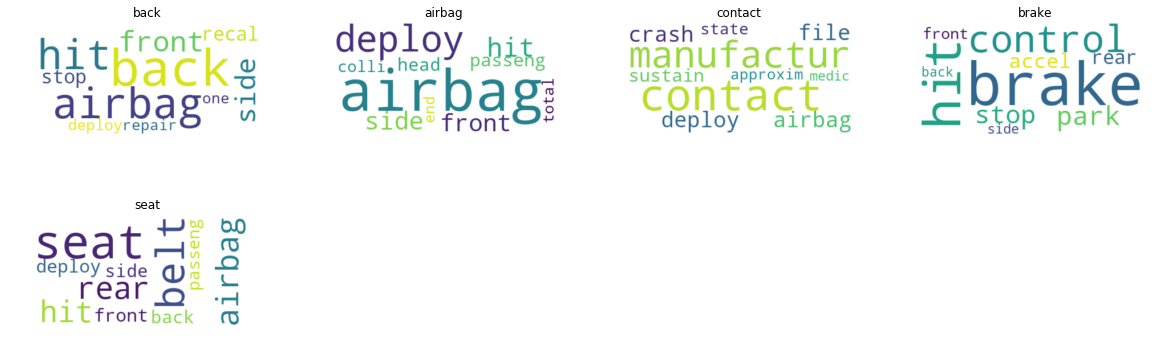

In [1074]:
plt.figure(figsize=(20,20));
wordcloud_injury=dict()
for i in range(num_clusters1):
    #counts_injury[i]= cluster_injury[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)
    wordcloud_injury[i] = WordCloud(background_color='white', max_words=10).fit_words(counts_injury[i])
    plt.subplot(6,4,i+1);
    plt.subplots_adjust(hspace=0.5, wspace=0.3);
    plt.imshow(wordcloud_injury[i], interpolation='bilinear')
    plt.title(counts_injury[i].index[0])
    plt.axis("off")
plt.show();

With 6 clusters, two clusters were forming with the same most frequent term 'airbag', so only 5 clusters were created.

**airbag** and **hit** appears in most of the clusters.

In [1075]:
# Creating table for the Most Frequent Terms in Each CLuster Identified in Injury involving Incidents

freq_terms_injury=pd.DataFrame(injury_data1.groupby('clusters')['CDESCR'].count())
freq_terms_injury.columns= ['# of Complaints']
freq_terms_injury['Most Frequent Terms']= ''
freq_terms_injury['Frequency of the Most Frequent Terms']=''

u=[]
for i in range(num_clusters1):
    u.append(counts_injury[i].index)

for i in range(num_clusters1):
    freq_terms_injury.at[i,'Most Frequent Terms']=list(u[i])

w=[]
for i in range(num_clusters1):
    w.append(counts_injury[i].values)

for i in range(num_clusters1):
    freq_terms_injury.at[i,'Frequency of the Most Frequent Terms']=list(w[i])

### Table: The most frequent terms in each cluster identified in Injury Incidents

In [1090]:
freq_terms_injury

,# of Complaints,Most Frequent Terms,Frequency of the Most Frequent Terms
clusters,,,
0,499,"[back, airbag, hit, front, side, recal, stop, deploy, repair, one]","[176, 167, 160, 159, 154, 142, 140, 127, 122, 120]"
1,540,"[airbag, deploy, hit, side, front, passeng, head, colli, total, end]","[535, 506, 216, 196, 178, 139, 132, 104, 99, 89]"
2,412,"[contact, manufactur, airbag, deploy, crash, file, sustain, state, approxim, medic]","[411, 317, 309, 307, 303, 303, 292, 224, 211, 184]"
3,705,"[brake, hit, control, park, stop, accel, rear, front, side, back]","[193, 137, 137, 126, 125, 121, 110, 106, 98, 88]"
4,309,"[seat, belt, rear, airbag, hit, deploy, front, back, side, passeng]","[282, 194, 110, 109, 99, 98, 95, 91, 90, 87]"


### Time Trend Analysis of Injury Incidents Clusters

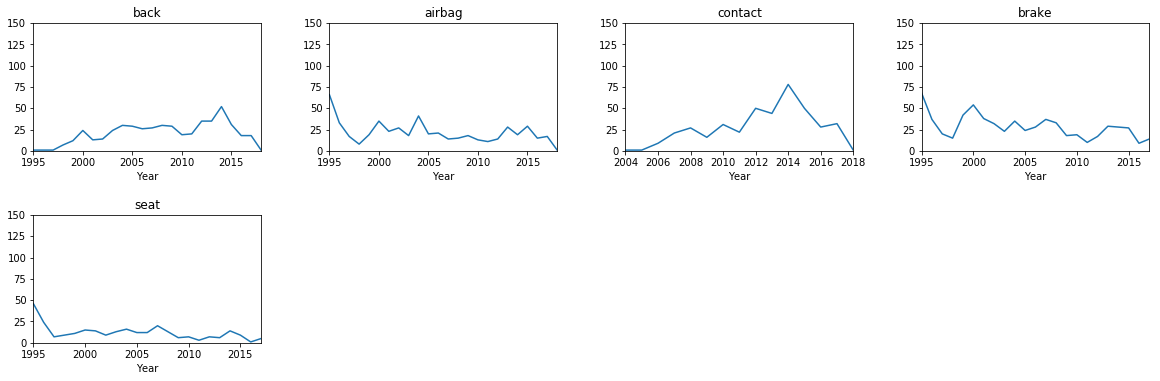

In [1091]:
plt.figure(figsize=(20,20));
for i in range(num_clusters1):
    cluster_injury[i]= injury_data1[injury_data1['clusters']==i]
    cluster_injury[i]=cluster_injury[i][cluster_injury[i]['FAILDATE']>1994]
    counts_injury[i]= cluster_injury[i]['CDESCR'].str.split(expand=True).stack().value_counts().head(10)
    plt.subplot(6,4,i+1);
    plt.subplots_adjust(hspace=0.5, wspace=0.3);
    cluster_injury[i].groupby('FAILDATE')['clusters'].count().plot(title=counts_injury[i].index[0]);
    plt.xlabel("Year");
    
    plt.ylim((0,150));
plt.show();
plt.tight_layout();


From the above time trend graphs of incidents involving injury, we can notice that the **contact** cluster which was a concerning cluster in previous study has been declining over the past few years

**airbag** and **seat** cluster have been steady for the past few years.

**back** cluster which saw a peak around 2014 has been declining.

Terms such as "seat", "airbag", "brake" appeared in clusters of both severity level.

Even though KMeans clustering produced consistent results with the previous study, I will try to create clusters using Hierarchical clustering. 

One thing left is the comparison of clusters across severity levels.


### References:
1. Ghazizadeh, M., McDonald, A.D., and Lee, J.D. (2014). A text mining approach to decoding free-response consumer complaints: Insights from the NHTSA vehicle owner’s complaint database. Human Factors: The Journal of the Human Factors and Ergonomics Society, 56(6), 1189-1203.
2. https://www-odi.nhtsa.dot.gov/
3. Dumais, S. T. (2004). Latent semantic analysis. Annual Review of Information Science and Technology, 38, 188–230.

***Prepared by:***
***Ashish Jatav***